In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils
import stacked_vae_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.distributions import Categorical

import timeit

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [3]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001, propn_labeled=0)

In [4]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  0
num_train_unlabled:  60
num_test:  10


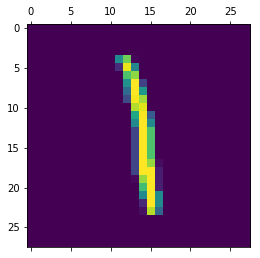

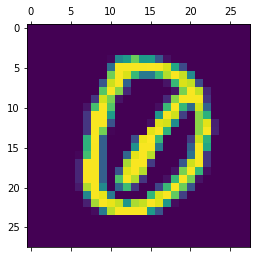

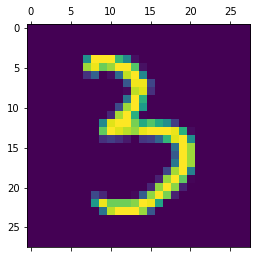

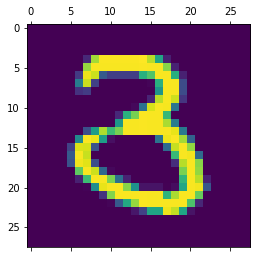

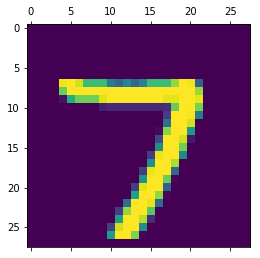

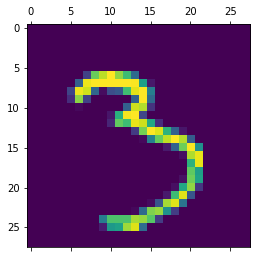

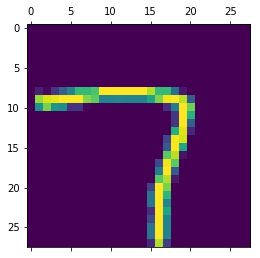

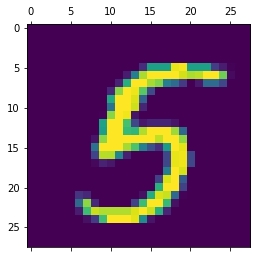

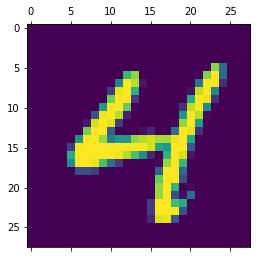

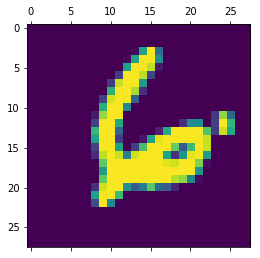

In [5]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

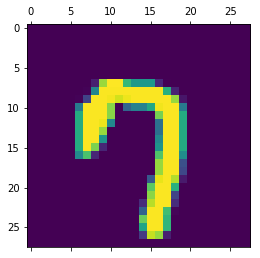

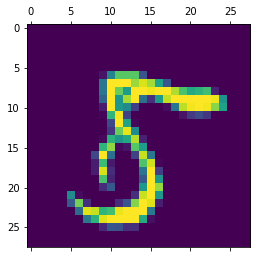

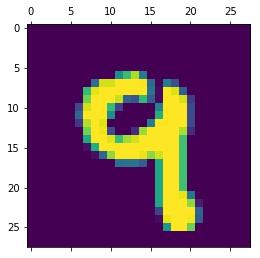

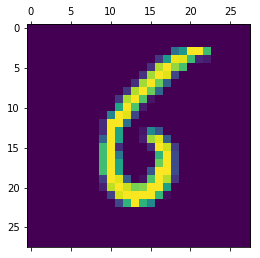

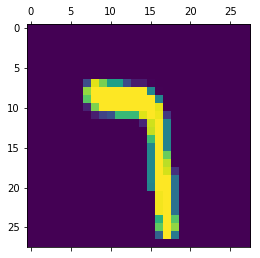

In [6]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())
    assert np.all(test_set[i]['image'].detach().numpy() <= 1)
    assert np.all(test_set[i]['image'].detach().numpy() >= 0)

In [7]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [8]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [9]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [10]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

# Define VAE

In [11]:
latent_dim = 5
n_classes = 10

In [12]:
vae = stacked_vae_lib.Model1VAE(latent_dim = latent_dim)

In [13]:
print(vae.parameters)

<bound method Module.parameters of Model1VAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=5, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [14]:
28 * 28

784

In [15]:
2 * 28 * 28

1568

In [16]:
### Check things run

In [17]:
# check dimensions of encoder output

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], z = None)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [18]:
recon_mean = \
    vae.decoder(latent_means, z = None)
    
assert recon_mean.shape[0] == batchsize
assert recon_mean.shape[1] == slen
assert recon_mean.shape[2] == slen

In [19]:
vae.loss(data_unlabeled['image'])

tensor(543.7538)

# Check gradient works 

In [20]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [21]:
vae_params0 = get_vae_params(vae)

In [22]:
assert np.any(np.isnan(vae_params0)) == False

In [23]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [24]:
loss = vae.loss(data_unlabeled['image'])

In [25]:
loss.backward()
optimizer.step()

In [26]:
vae_params1 = get_vae_params(vae)

In [27]:
assert np.any(np.isnan(vae_params1)) == False

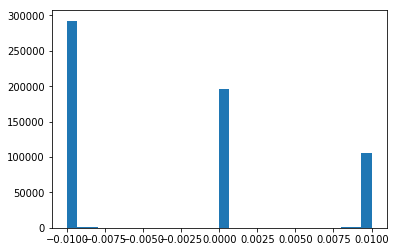

In [28]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [29]:
loss2= vae.loss(data_unlabeled['image'])

In [30]:
assert np.isfinite(loss2.detach().numpy())

In [31]:
vae.train_vae(train_loader_unlabeled, 
                test_loader, 
                n_epoch = 5, print_every = 2, outfile = './test')

  * init train recon loss: 385.899353;
  * init test recon loss: 377.8187866;
[1] unlabeled_loss: 332.4594727  	[0.1 seconds]
[2] unlabeled_loss: 210.5995483  	[0.1 seconds]
  * train recon loss: 175.1072388;
  * test recon loss: 166.870224;
[3] unlabeled_loss: 162.8294678  	[0.1 seconds]
[4] unlabeled_loss: 148.5374908  	[0.1 seconds]
  * train recon loss: 144.1533661;
  * test recon loss: 141.1417084;
[5] unlabeled_loss: 144.1122284  	[0.0 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

